In [3]:
pip install smolagents yfinance prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.

In [25]:
pip install prophet

In [26]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from smolagents import CodeAgent, ToolCallingAgent
from transformers import pipeline
from prophet import Prophet

In [30]:
# Define the agent for fetching stock data
class StockDataAgent(CodeAgent):
    def __init__(self, company_ticker):
        self.company_ticker = company_ticker

    def run(self):
        # Fetch stock data using yfinance
        stock_data = yf.Ticker(self.company_ticker)
        return stock_data

# Define the agent for generating financial report
class FinancialReportAgent(CodeAgent):
    def __init__(self, stock_data):
        self.stock_data = stock_data

    def run(self):
        # Generate financial report
        info = self.stock_data.info
        report = f"# Financial Report for {info['shortName']}\n\n"
        report += f"**Sector:** {info['sector']}\n\n"
        report += f"**Industry:** {info['industry']}\n\n"
        report += f"**Market Cap:** {info['marketCap']}\n\n"
        report += f"**52 Week High:** {info['fiftyTwoWeekHigh']}\n\n"
        report += f"**52 Week Low:** {info['fiftyTwoWeekLow']}\n\n"
        return report

# Define the agent for generating trend charts
class TrendChartAgent(CodeAgent):
    def __init__(self, stock_data, start_date, end_date, purchase_price, forecast):
        self.stock_data = stock_data
        self.start_date = start_date
        self.end_date = end_date
        self.purchase_price = purchase_price
        self.forecast = forecast

    def run(self):
        # Generate trend charts
        hist = self.stock_data.history(start=self.start_date, end=self.end_date)
        plt.figure(figsize=(10, 5))
        plt.plot(hist.index, hist['Close'], label='Close Price')
        plt.axhline(y=self.purchase_price, color='r', linestyle='--', label='Purchase Price')
        plt.plot(self.forecast['ds'], self.forecast['yhat'], label='Forecast', linestyle='--', color='g')
        plt.title('Stock Price Trend')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.savefig('trend_chart.png')
        return "!Trend Chart"

# Define the agent for generating financial overview
class FinancialOverviewAgent(CodeAgent):
    def __init__(self, stock_data):
        self.stock_data = stock_data

    def run(self):
        # Generate financial overview
        financials = self.stock_data.financials
        overview = f"# Financial Overview for {self.stock_data.info['shortName']}\n\n"
        overview += financials.to_markdown()
        return overview

# Define the agent for generating narrative using LLM
class FinancialNarrativeAgent(CodeAgent):
    def __init__(self, financial_overview):
        self.financial_overview = financial_overview
        self.model = pipeline("text2text-generation", model="google/flan-t5-large")

    def run(self):
        # Generate narrative using LLM
        prompt = f"Generate a narrative describing the most relevant items of the financial overview:\n\n{self.financial_overview}"
        narrative = self.model(prompt, max_length=500)[0]['generated_text']
        return narrative

# Define the agent for providing investment status
class InvestmentStatusAgent(CodeAgent):
    def __init__(self, stock_data, purchase_price, purchase_date):
        self.stock_data = stock_data
        self.purchase_price = purchase_price
        self.purchase_date = purchase_date

    def run(self):
        # Fetch historical data from the purchase date to today
        hist = self.stock_data.history(start=self.purchase_date)

        # Get the closing price on the purchase date and today
        purchase_close_price = hist.loc[self.purchase_date]['Close']
        current_close_price = hist['Close'].iloc[-1]

        # Calculate investment status
        investment_status = current_close_price - self.purchase_price

        status_report = f"# Investment Status\n\n"
        status_report += f"**Purchase Date:** {self.purchase_date}\n\n"
        status_report += f"**Purchase Price:** {self.purchase_price}\n\n"
        status_report += f"**Current Price:** {current_close_price}\n\n"

        if investment_status > 0:
            status_report += f"**Status:** Profit of {investment_status} per share\n\n"
        else:
            status_report += f"**Status:** Loss of {abs(investment_status)} per share\n\n"

        return status_report

# Define the agent for forecasting future prices using Prophet
class ForecastingAgent(CodeAgent):
    def __init__(self, stock_data, start_date, end_date):
        self.stock_data = stock_data
        self.start_date = start_date
        self.end_date = end_date

    def run(self):
        # Generate forecast forward of 10% of historical data length using Prophet
        hist = self.stock_data.history(start=self.start_date, end=self.end_date)

        # Prepare data for Prophet model
        df = hist.reset_index()[['Date', 'Close']]
        df.columns = ['ds', 'y']

        # Remove timezone information from 'ds' column
        df['ds'] = df['ds'].dt.tz_localize(None)

        # Calculate forecast period (10% of historical data length)
        forecast_period = int(len(df) * 0.1)

        # Fit model and generate forecast
        model = Prophet()
        model.fit(df)

        future_dates = model.make_future_dataframe(periods=forecast_period)
        forecast = model.predict(future_dates)

        return forecast[['ds', 'yhat']]

# Define the multi-agent system
class FinancialReportMultiAgent(ToolCallingAgent):
    def __init__(self, company_ticker, start_date, end_date, purchase_price, purchase_date):
        self.company_ticker = company_ticker
        self.start_date = start_date
        self.end_date = end_date
        self.purchase_price = purchase_price
        self.purchase_date = purchase_date

    def run(self):
        # Create agents
        stock_data_agent = StockDataAgent(self.company_ticker)
        stock_data = stock_data_agent.run()

        financial_report_agent = FinancialReportAgent(stock_data)
        financial_report = financial_report_agent.run()

        forecasting_agent = ForecastingAgent(stock_data, self.start_date, self.end_date)
        forecast = forecasting_agent.run()

        trend_chart_agent = TrendChartAgent(stock_data, self.start_date, self.end_date, self.purchase_price, forecast)
        trend_chart = trend_chart_agent.run()

        financial_overview_agent = FinancialOverviewAgent(stock_data)
        financial_overview = financial_overview_agent.run()

        financial_narrative_agent = FinancialNarrativeAgent(financial_overview)
        financial_narrative = financial_narrative_agent.run()

        investment_status_agent = InvestmentStatusAgent(stock_data, self.purchase_price, self.purchase_date)
        investment_status = investment_status_agent.run()

        # Combine results
        report = financial_report + "\n\n" + trend_chart + "\n\n" + financial_overview + "\n\n" + financial_narrative + "\n\n" + investment_status
        return report

In [28]:
# Receive human input for company ticker, date range, and investment details
company_ticker = input("Enter the company ticker: ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")
purchase_price = float(input("Enter the purchase price: "))
purchase_date = input("Enter the purchase date (YYYY-MM-DD): ")

Enter the company ticker: AAPL
Enter the start date (YYYY-MM-DD): 2021-01-01
Enter the end date (YYYY-MM-DD): 2024-12-31
Enter the purchase price: 226.68
Enter the purchase date (YYYY-MM-DD): 2024-08-26


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntw3brxh/cn6r0qll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntw3brxh/229m02s6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2719', 'data', 'file=/tmp/tmpntw3brxh/cn6r0qll.json', 'init=/tmp/tmpntw3brxh/229m02s6.json', 'output', 'file=/tmp/tmpntw3brxh/prophet_modeln7l8b_ef/prophet_model-20250109141542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:15:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (1634 > 512). Running t

# Financial Report for Apple Inc.

**Sector:** Technology

**Industry:** Consumer Electronics

**Market Cap:** 3668604616704

**52 Week High:** 260.1

**52 Week Low:** 164.08



!Trend Chart

# Financial Overview for Apple Inc.

|                                                            |   2024-09-30 00:00:00 |   2023-09-30 00:00:00 |   2022-09-30 00:00:00 |   2021-09-30 00:00:00 |   2020-09-30 00:00:00 |
|:-----------------------------------------------------------|----------------------:|----------------------:|----------------------:|----------------------:|----------------------:|
| Tax Effect Of Unusual Items                                |           0           |           0           |           0           |           0           |         nan           |
| Tax Rate For Calcs                                         |           0.240912    |           0.147192    |           0.162       |           0.133       |         nan           |
| Normalized EBITDA                    

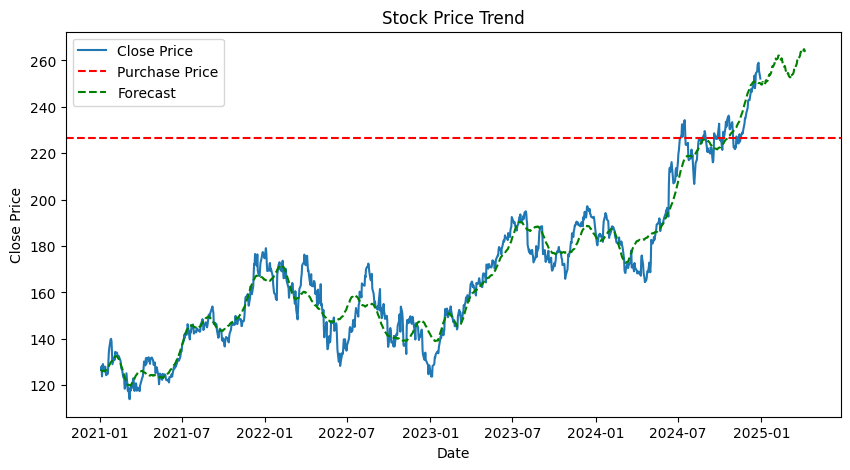

In [31]:
# Create and run the multi-agent system
multi_agent_system = FinancialReportMultiAgent(company_ticker, start_date, end_date, purchase_price, purchase_date)
report = multi_agent_system.run()

# Output the report in markdown format
print(report)

# Financial Report for Apple Inc.

**Sector:** Technology

**Industry:** Consumer Electronics

**Market Cap:** 3668604616704

**52 Week High:** 260.1

**52 Week Low:** 164.08



!Trend Chart

# Financial Overview for Apple Inc.

|                                                            |   2024-09-30 00:00:00 |   2023-09-30 00:00:00 |   2022-09-30 00:00:00 |   2021-09-30 00:00:00 |   2020-09-30 00:00:00 |
|:-----------------------------------------------------------|----------------------:|----------------------:|----------------------:|----------------------:|----------------------:|
| Tax Effect Of Unusual Items                                |           0           |           0           |           0           |           0           |         nan           |
| Tax Rate For Calcs                                         |           0.240912    |           0.147192    |           0.162       |           0.133       |         nan           |
| Normalized EBITDA                                          |           1.34661e+11 |           1.2582e+11  |           1.30541e+11 |           1.23136e+11 |         nan           |
| Net Income From Continuing Operation Net Minority Interest |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Reconciled Depreciation                                    |           1.1445e+10  |           1.1519e+10  |           1.1104e+10  |           1.1284e+10  |         nan           |
| Reconciled Cost Of Revenue                                 |           2.10352e+11 |           2.14137e+11 |           2.23546e+11 |           2.12981e+11 |         nan           |
| EBITDA                                                     |           1.34661e+11 |           1.2582e+11  |           1.30541e+11 |           1.23136e+11 |         nan           |
| EBIT                                                       |           1.23216e+11 |           1.14301e+11 |           1.19437e+11 |           1.11852e+11 |         nan           |
| Net Interest Income                                        |         nan           |          -1.83e+08    |          -1.06e+08    |           1.98e+08    |           8.9e+08     |
| Interest Expense                                           |         nan           |           3.933e+09   |           2.931e+09   |           2.645e+09   |           2.873e+09   |
| Interest Income                                            |         nan           |           3.75e+09    |           2.825e+09   |           2.843e+09   |           3.763e+09   |
| Normalized Income                                          |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Net Income From Continuing And Discontinued Operation      |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Total Expenses                                             |           2.67819e+11 |           2.68984e+11 |           2.74891e+11 |           2.56868e+11 |         nan           |
| Total Operating Income As Reported                         |           1.23216e+11 |           1.14301e+11 |           1.19437e+11 |           1.08949e+11 |         nan           |
| Diluted Average Shares                                     |         nan           |           1.58125e+10 |           1.63258e+10 |           1.68649e+10 |           1.75282e+10 |
| Basic Average Shares                                       |         nan           |           1.57442e+10 |           1.6216e+10  |           1.67013e+10 |           1.73521e+10 |
| Diluted EPS                                                |         nan           |           6.13        |           6.11        |           5.61        |           3.28        |
| Basic EPS                                                  |         nan           |           6.16        |           6.15        |           5.67        |           3.31        |
| Diluted NI Availto Com Stockholders                        |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Net Income Common Stockholders                             |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Net Income                                                 |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Net Income Including Noncontrolling Interests              |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Net Income Continuous Operations                           |           9.3736e+10  |           9.6995e+10  |           9.9803e+10  |           9.468e+10   |         nan           |
| Tax Provision                                              |           2.9749e+10  |           1.6741e+10  |           1.93e+10    |           1.4527e+10  |         nan           |
| Pretax Income                                              |           1.23485e+11 |           1.13736e+11 |           1.19103e+11 |           1.09207e+11 |         nan           |
| Other Income Expense                                       |           2.69e+08    |          -5.65e+08    |          -3.34e+08    |           6e+07       |         nan           |
| Other Non Operating Income Expenses                        |           2.69e+08    |          -5.65e+08    |          -3.34e+08    |           6e+07       |         nan           |
| Net Non Operating Interest Income Expense                  |         nan           |          -1.83e+08    |          -1.06e+08    |           1.98e+08    |           8.9e+08     |
| Interest Expense Non Operating                             |         nan           |           3.933e+09   |           2.931e+09   |           2.645e+09   |           2.873e+09   |
| Interest Income Non Operating                              |         nan           |           3.75e+09    |           2.825e+09   |           2.843e+09   |           3.763e+09   |
| Operating Income                                           |           1.23216e+11 |           1.14301e+11 |           1.19437e+11 |           1.08949e+11 |         nan           |
| Operating Expense                                          |           5.7467e+10  |           5.4847e+10  |           5.1345e+10  |           4.3887e+10  |         nan           |
| Research And Development                                   |           3.137e+10   |           2.9915e+10  |           2.6251e+10  |           2.1914e+10  |         nan           |
| Selling General And Administration                         |           2.6097e+10  |           2.4932e+10  |           2.5094e+10  |           2.1973e+10  |         nan           |
| Gross Profit                                               |           1.80683e+11 |           1.69148e+11 |           1.70782e+11 |           1.52836e+11 |         nan           |
| Cost Of Revenue                                            |           2.10352e+11 |           2.14137e+11 |           2.23546e+11 |           2.12981e+11 |         nan           |
| Total Revenue                                              |           3.91035e+11 |           3.83285e+11 |           3.94328e+11 |           3.65817e+11 |         nan           |
| Operating Revenue                                          |           3.91035e+11 |           3.83285e+11 |           3.94328e+11 |           3.65817e+11 |         nan           |

The company reported a net income of $1.34661 million for the fiscal year ended December 31, 2019.

# Investment Status

**Purchase Date:** 2024-08-26

**Purchase Price:** 226.68

**Current Price:** 242.6999969482422

**Status:** Profit of 16.01999694824218 per share


